## Домашнее задание к лекции «Feature Selection»

#### Преподаватель: Наталья Баданина

Задания:

Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются.
Дополнительно 4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC 5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

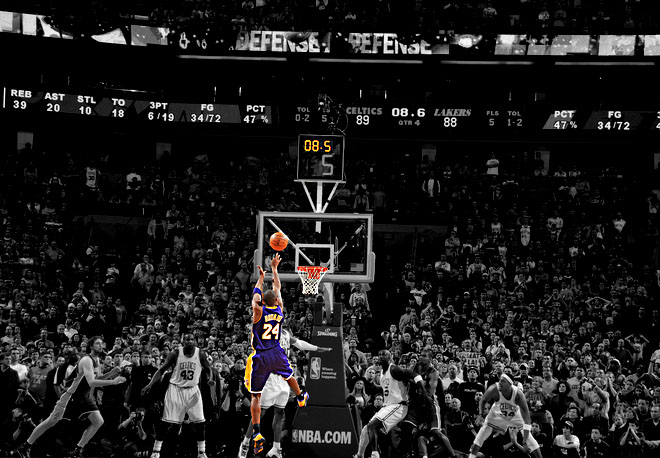

In [2]:
data = pd.read_csv('kobe.csv')
data = data[data['shot_made_flag'].notnull()]
data = data.drop(['shot_id'], axis=1)

##### 1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
##### 2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.

In [4]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR


In [5]:
target = data['shot_made_flag']
target.unique()

array([0., 1.])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         25697 non-null  object 
 1   combined_shot_type  25697 non-null  object 
 2   game_event_id       25697 non-null  int64  
 3   game_id             25697 non-null  int64  
 4   lat                 25697 non-null  float64
 5   loc_x               25697 non-null  int64  
 6   loc_y               25697 non-null  int64  
 7   lon                 25697 non-null  float64
 8   minutes_remaining   25697 non-null  int64  
 9   period              25697 non-null  int64  
 10  playoffs            25697 non-null  int64  
 11  season              25697 non-null  object 
 12  seconds_remaining   25697 non-null  int64  
 13  shot_distance       25697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           25697 non-null  object 
 16  shot

###### Объединим столбцы с оставшимся временем в один столбец

In [7]:
data['remain_time'] = data['minutes_remaining']*60 + data['seconds_remaining']

###### Удалим столбцы с id и названием команды за которую играл Kobe Bryant - она одна - Los Angeles Lakers 
###### Удалим matchup - данные дублируются в столбце opponent

In [8]:
data.team_name.unique()

array(['Los Angeles Lakers'], dtype=object)

In [9]:
data = data.drop(['team_id', 'team_name', 'matchup','minutes_remaining', 'seconds_remaining'], axis=1)

###### Удалим признаки game_event_id, game_id не несущие информации о результате броска

In [10]:
data = data.drop(['game_event_id', 'game_id'], axis=1)

<AxesSubplot:>

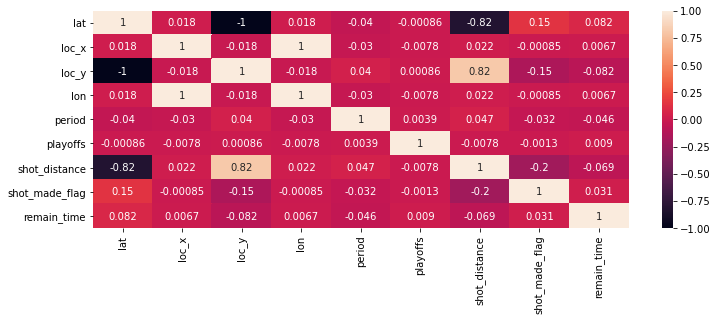

In [11]:
corr = data.corr()
plt.figure(figsize=[12,4])
sns.heatmap(corr, annot=True)

###### Признаки lat и loc_y,  lon и loc_x идентичны. Исключим lat и lon.

In [12]:
data = data.drop(['lat', 'lon'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         25697 non-null  object 
 1   combined_shot_type  25697 non-null  object 
 2   loc_x               25697 non-null  int64  
 3   loc_y               25697 non-null  int64  
 4   period              25697 non-null  int64  
 5   playoffs            25697 non-null  int64  
 6   season              25697 non-null  object 
 7   shot_distance       25697 non-null  int64  
 8   shot_made_flag      25697 non-null  float64
 9   shot_type           25697 non-null  object 
 10  shot_zone_area      25697 non-null  object 
 11  shot_zone_basic     25697 non-null  object 
 12  shot_zone_range     25697 non-null  object 
 13  game_date           25697 non-null  object 
 14  opponent            25697 non-null  object 
 15  remain_time         25697 non-null  int64  
dtypes: f

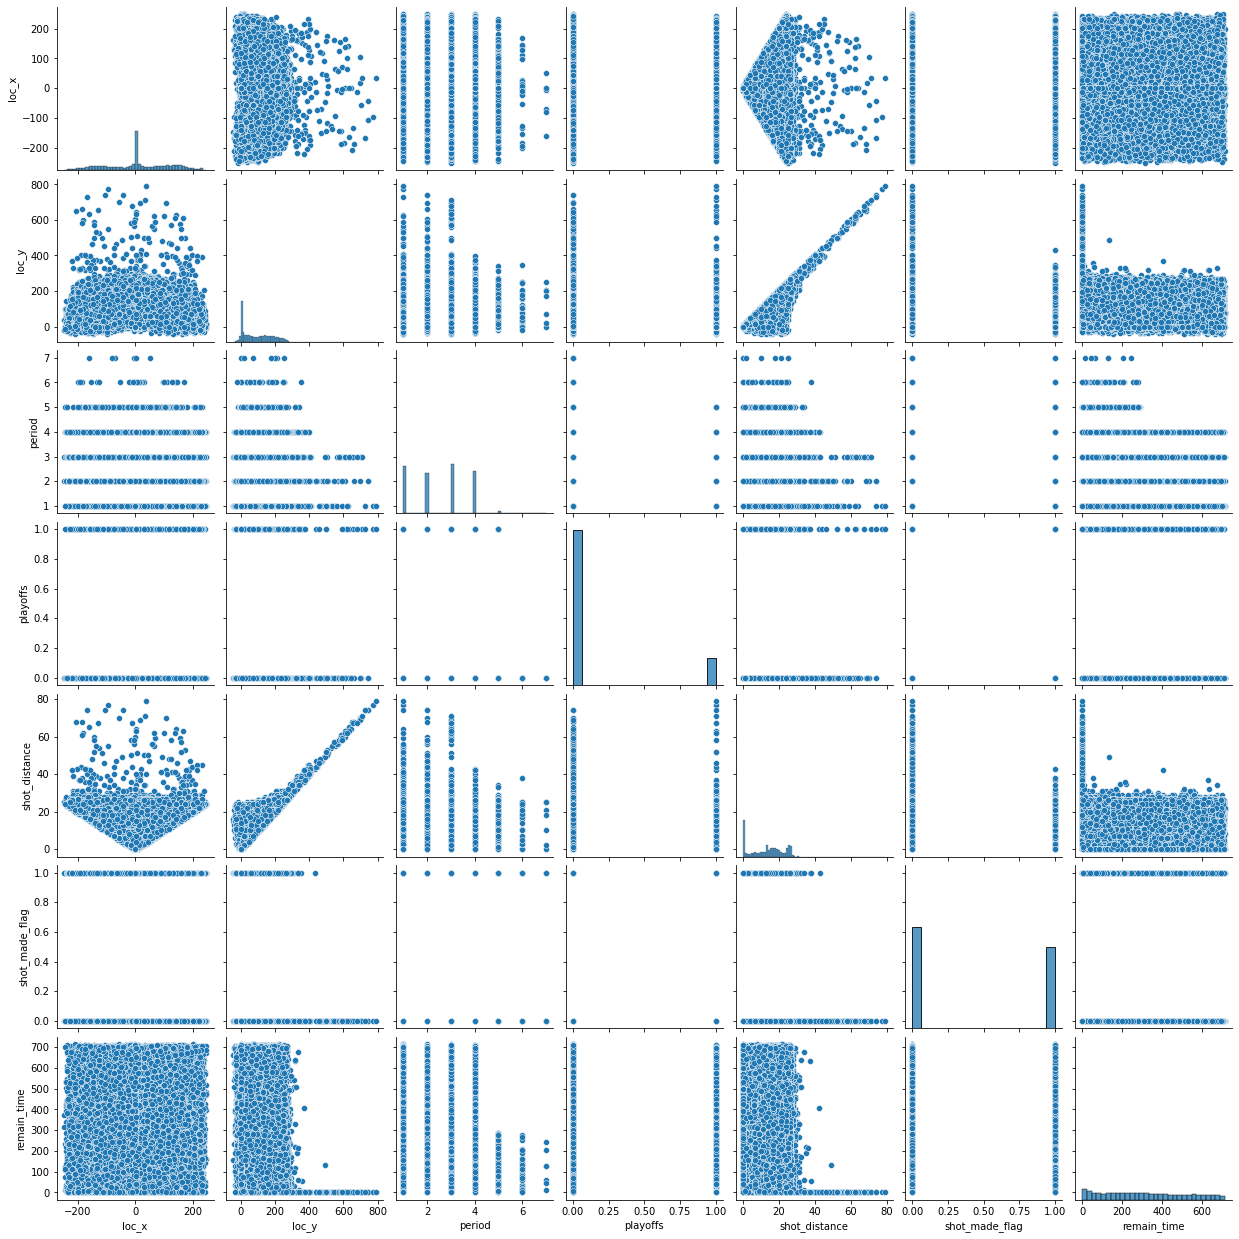

In [13]:
sns.pairplot(data)

###### Оценим категориальные данные

In [14]:
data.describe(include=['object'])

,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,opponent
count,25697,25697,25697,25697,25697,25697,25697,25697,25697
unique,55,6,20,2,6,7,5,1558,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,2016-04-13,SAS
freq,15836,19710,1924,20285,11289,10532,7857,43,1638


###### Разделим дату на год и месяц

In [15]:
data["game_date"] = pd.to_datetime(data["game_date"])
data["game_year"] = data["game_date"].dt.year
data["game_month"] = data["game_date"].dt.month
data = data.drop("game_date", axis=1)

###### action_type содержит 55 признаков. Сократим их кол-во, определив наименее результативные в группу rare_action

In [16]:
pd.DataFrame({"counts": data["action_type"].value_counts().sort_values()[:25]})

,counts
Driving Floating Bank Jump Shot,1
Running Tip Shot,1
Running Slam Dunk Shot,1
Putback Slam Dunk Shot,2
Turnaround Finger Roll Shot,2
Tip Layup Shot,2
Running Pull-Up Jump Shot,3
Driving Bank shot,3
Putback Dunk Shot,3
Driving Floating Jump Shot,3


In [17]:
rare_action_types = data["action_type"].value_counts().sort_values().index.values[:20]
data.loc[data["action_type"].isin(rare_action_types), "action_type"] = "rare_action"

###### Преобразуем категориальные признаки в векторные

In [18]:
cat = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent', 'loc_x', 'loc_y']

for var in cat:
    dummies = pd.get_dummies(data[var])
    dummies = dummies.add_prefix("{}#".format(var))
    data.drop(var, axis=1, inplace=True)
    data = data.join(dummies)

In [19]:
data = data.drop('shot_made_flag', axis=1)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Columns: 1087 entries, playoffs to loc_y#791
dtypes: int64(3), uint8(1084)
memory usage: 28.4 MB


In [21]:
from sklearn.preprocessing import LabelEncoder
Y = target
le = LabelEncoder()
Y = le.fit_transform(Y)
Y

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [22]:
X = data
X.shape, Y.shape

((25697, 1087), (25697,))

###### Построим случайный лес и выведем важность признаков

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)

In [24]:
clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=0.5, min_samples_leaf=20,
                       n_estimators=10, n_jobs=-1)

In [25]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

Train RF:
ROC AUC: 0.7083
Test RF:
ROC AUC: 0.7013


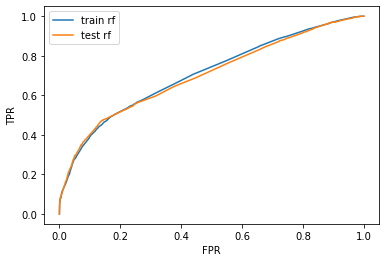

In [26]:
y_pred_test_rf = clf_rf.predict_proba(X_test)[:, 1]
y_pred_train_rf = clf_rf.predict_proba(X_train)[:, 1]

print('Train RF:')
show_auc(y_train, y_pred_train_rf, 'train rf')
print('Test RF:')
show_auc(y_test, y_pred_test_rf, 'test rf')
plt.legend();

In [27]:
imp = pd.Series(clf_rf.feature_importances_)
imp2 = imp.sort_values(ascending=False).loc[ imp > 0.01]

features = data.iloc[:, imp2.index].columns
for i in range(len(features)):
    print(f"{features[i]}\t- {imp2.values[i]:.6f}", imp2.index[i])
imp2.index

action_type#Jump Shot	- 0.433127 21
action_type#Layup Shot	- 0.122688 22
combined_shot_type#Dunk	- 0.110411 40
combined_shot_type#Jump Shot	- 0.081115 42
action_type#Running Jump Shot	- 0.039896 30
action_type#Driving Layup Shot	- 0.039883 9
shot_zone_basic#Restricted Area	- 0.024217 85
remain_time	- 0.023083 2
shot_distance	- 0.017700 1
combined_shot_type#Layup	- 0.010097 43


Int64Index([21, 22, 40, 42, 30, 9, 85, 2, 1, 43], dtype='int64')

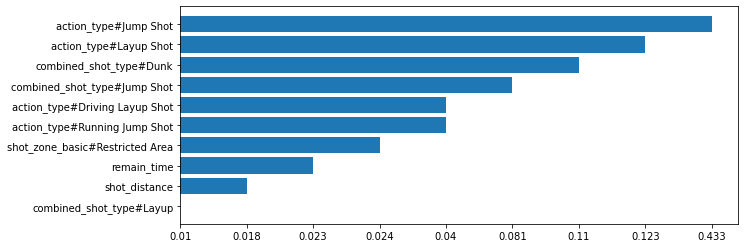

In [28]:
feat_imp_dict = {col:np.round(imp, 3) for col, imp in zip(features, imp2.values)}
feat_imp_dict = np.array(sorted(feat_imp_dict.items(), key=lambda x:x[1]))
labels = list(feat_imp_dict[:,0])
importances = list(feat_imp_dict[:,1])
y_pos = np.arange(len(labels))

plt.figure(figsize=(10,4))
plt.barh(y_pos, importances, align='center')
plt.yticks(y_pos, labels)
_ = plt.show()

In [ ]:
X_train = X_train.iloc[:,[21, 22, 40, 42, 30, 9, 85, 2, 1, 43]]
X_test = X_test.iloc[:,[21, 22, 40, 42, 30, 9, 85, 2, 1, 43]]

##### 3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются.

In [42]:
from sklearn.linear_model import  LogisticRegression, Lasso, RidgeClassifier
from sklearn.preprocessing import StandardScaler

In [82]:
st = StandardScaler()
X_train_std = st.fit_transform(X_train)
X_test_std = st.transform(X_test)

array([[ 0.79028375, -0.30097157, -0.20331303, ..., -1.0827915 ,
        -0.05048714, -0.46262877],
       [ 0.79028375, -0.30097157, -0.20331303, ...,  0.84693798,
        -0.37050786, -0.46262877],
       [-1.26536829, -0.30097157, -0.20331303, ..., -1.3509425 ,
        -0.37050786, -0.46262877],
       ...,
       [-1.26536829, -0.30097157, -0.20331303, ...,  0.10952275,
         0.26953359, -0.46262877],
       [ 0.79028375, -0.30097157, -0.20331303, ...,  0.36809692,
         1.12292219, -0.46262877],
       [ 0.79028375, -0.30097157, -0.20331303, ...,  1.76152441,
         0.05618644, -0.46262877]])

In [44]:
lr = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C = 0.1)
lr.fit(X_train_std, y_train)

LogisticRegression(C=0.1, multi_class='ovr', penalty='l1', solver='liblinear')

In [46]:
ls = Lasso(alpha=1.0)
ls.fit(X_train_std, y_train)

Lasso()

In [47]:
rg = RidgeClassifier(alpha=1.0)
rg.fit(X_train_std, y_train)

RidgeClassifier()

In [79]:
# Сравнительная таблица коэффициентов
dict = {'features':features, 'LogisticRegression': lr.coef_[0], 'Lasso': ls.coef_[0], 'RidgeClassifier': rg.coef_[0]}
coef = pd.DataFrame(data = dict)
coef

,features,LogisticRegression,Lasso,RidgeClassifier
0,action_type#Jump Shot,-0.604188,-0.0,-0.295936
1,action_type#Layup Shot,-0.338044,-0.0,-0.167512
2,combined_shot_type#Dunk,0.425810,-0.0,0.152641
3,combined_shot_type#Jump Shot,0.033891,-0.0,0.042561
4,action_type#Running Jump Shot,0.106098,-0.0,0.045300
5,action_type#Driving Layup Shot,0.033388,-0.0,0.011326
6,shot_zone_basic#Restricted Area,-0.020632,-0.0,-0.024626
7,remain_time,0.059765,-0.0,0.027024
8,shot_distance,0.033026,-0.0,0.016376
9,combined_shot_type#Layup,0.176912,-0.0,0.121599


##### График коэффициентов

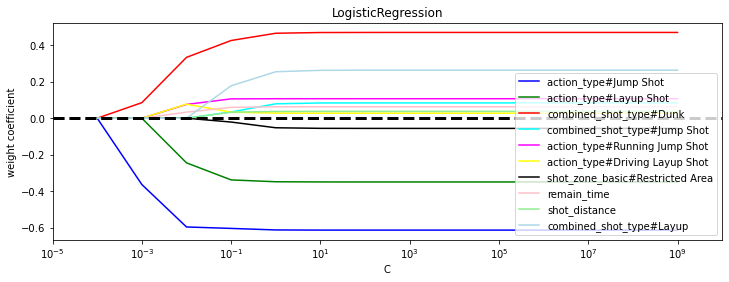

In [118]:
plt.figure(figsize=[12,4]) 
plt.title('LogisticRegression')
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 10.):
    lr = LogisticRegression(penalty='l1', C=10.**c, solver='liblinear', 
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[0])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**10])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(features) 
plt.show()

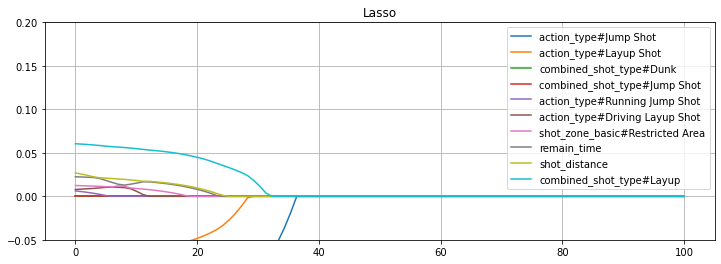

In [117]:
import warnings
warnings.filterwarnings('ignore')

lg_l, pred_l = [], []

list_l=list(2**np.linspace(-10,10,100))

for i in range(len(list_l)):
    m_l = Lasso(alpha=list_l[i]).fit(X_train_std, y_train)
    lg_l.append(m_l)
    pred_l.append(sorted(m_l.coef_))

plt.figure(figsize=[12,4])
plt.title('Lasso')
x_l = np.linspace(0,len(pred_l),len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l,np.sign(i)*np.abs(i)) 
plt.ylim(-0.05,0.2)  
plt.legend(features)      
plt.grid()

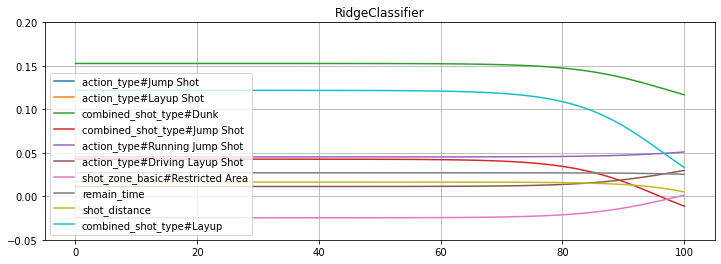

In [116]:
plt.figure(figsize=[12,4])
plt.title('RidgeClassifier')

lg_l,pred_l = [], []

list_l=list(2**np.linspace(-10,10,100))

for i in range(len(list_l)):
    m_l = RidgeClassifier(alpha=list_l[i]).fit(X_train_std, y_train)
    lg_l.append(m_l)
    pred_l.append(sorted(m_l.coef_))
x_l = np.linspace(0, len(pred_l), len(pred_l))
for i in np.vstack(pred_l).T:
    plt.plot(x_l, np.sign(i)*np.abs(i)) 
plt.ylim(-0.05,0.2)  
plt.legend(features, loc='lower left')
plt.grid() 

### Вывод: Веса менее значимых признаков обнуляются быстрее

##### 4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC


LogisticRegression
Lasso
RidgeClassifier
ROC AUC: 0.6888
ROC AUC: 0.5000
ROC AUC: 0.6640


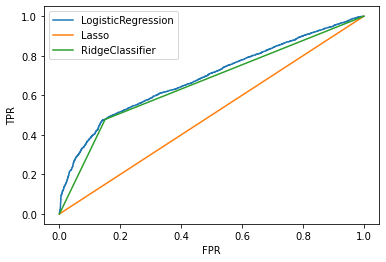

In [129]:
y_pred_proba_lr = lr.predict_proba(X_test_std)[:, 1]
y_pred_ls = ls.predict(X_test_std)
y_pred_rg = rg.predict(X_test_std)
# Оцениваем верность модели на тестовых данных
lr.score(X_test_std, y_test)
ls.score(X_test_std, y_test)
rg.score(X_test_std, y_test)
print("LogisticRegression")
print("Lasso")
print("RidgeClassifier")
show_auc(y_test, y_pred_proba_lr, 'LogisticRegression')
show_auc(y_test, y_pred_ls, 'Lasso')
show_auc(y_test, y_pred_rg, 'RidgeClassifier')
plt.legend()
plt.show()

##### 5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [132]:
from sklearn.decomposition import PCA

In [133]:
pca = PCA(n_components = None)

In [134]:
X_train_pca = pca.fit_transform(X_train_std)

In [135]:
pca.explained_variance_ratio_

array([0.46570138, 0.12520846, 0.11171731, 0.10777784, 0.10045075,
       0.03539521, 0.03068658, 0.01398391, 0.00542184, 0.00365671])

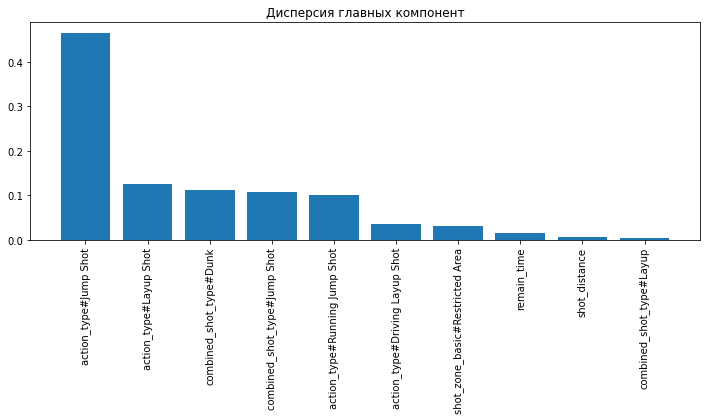

In [139]:
plt.figure(figsize=[12,4])
plt.title('Дисперсия главных компонент')
plt.bar(features, pca.explained_variance_ratio_, align='center')
plt.xticks(rotation=90)
plt.show()

#### Вывод: первая компонента объясняет 47% дисперсии данных, первые пять компонент - 90%